In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from xgboost import XGBRegressor 
from sklearn.model_selection import train_test_split  
from math import sqrt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

li = [pd.read_csv("dataset/marathon_results_2016.csv"), pd.read_csv("dataset/marathon_results_2017.csv"),
      pd.read_csv("dataset/marathon_results_2015.csv")]
df = pd.concat(li,axis=0,ignore_index=True)

def time_to_min(string):
    if string != '-':
        time_segments = string.split(':')
        hours = int(time_segments[0])
        mins = int(time_segments[1])
        sec = int(time_segments[2])
        time = hours*60 + mins + np.true_divide(sec,60)
        return time
    else:
        return -1

def gender_to_numeric(value):
    if value == 'M':
        return 0
    else:
        return 1

df['Half_min'] = df.Half.apply(lambda x: time_to_min(x))
df['Full_min'] = df['Official Time'].apply(lambda x: time_to_min(x))
df['split_ratio'] = (df['Full_min'] - df['Half_min'])/(df['Half_min'])

df_split = df[df.Half_min > 0]

df['5K_mins'] = df['5K'].apply(lambda x: time_to_min(x))
df['10K_mins'] = df['10K'].apply(lambda x: time_to_min(x))
df['10K_mins'] = df['10K_mins'] - df['5K_mins'] 

df['15K_mins'] = df['15K'].apply(lambda x: time_to_min(x))
df['15K_mins'] = df['15K_mins'] - df['10K_mins'] -  df['5K_mins']

df['20K_mins'] = df['20K'].apply(lambda x: time_to_min(x))
df['20K_mins'] = df['20K_mins'] -  df['15K_mins'] - df['10K_mins'] -  df['5K_mins']

df['25K_mins'] = df['25K'].apply(lambda x: time_to_min(x))
df['25K_mins'] = df['25K_mins'] - df['20K_mins'] -  df['15K_mins'] - df['10K_mins'] -  df['5K_mins']

df['30K_mins'] = df['30K'].apply(lambda x: time_to_min(x))
df['30K_mins'] = df['30K_mins'] -df['25K_mins'] - df['20K_mins'] -  df['15K_mins'] - df['10K_mins'] -  df['5K_mins']

df['35K_mins'] = df['35K'].apply(lambda x: time_to_min(x))
df['35K_mins'] = df['35K_mins'] -df['30K_mins'] -df['25K_mins'] - df['20K_mins'] -  df['15K_mins'] - df['10K_mins'] -  df['5K_mins']

df['40K_mins'] = df['40K'].apply(lambda x: time_to_min(x))
df['40K_mins'] = df['40K_mins'] -  df['35K_mins'] -df['30K_mins'] -df['25K_mins'] - df['20K_mins'] -  df['15K_mins'] - df['10K_mins'] -  df['5K_mins']

columns = ['20K_mins','15K_mins','10K_mins','5K_mins']
df['avg'] = df[columns].mean(axis = 1)
df['stdev'] = df[columns].std(axis = 1)

df_split = df[(~(df['5K'] == '-')) &(~(df['10K'] == '-'))&(~(df['15K'] == '-'))&(~(df['20K'] == '-'))&(~(df['25K'] == '-')) &(~(df['30K'] == '-')) &(~(df['35K'] == '-')) &(~(df['40K'] == '-'))]
df_split = df_split[df_split.split_ratio>0]


prediction_df = df_split[['Age','M/F', 'Half_min', 'Full_min','split_ratio','5K_mins','10K_mins','15K_mins','20K_mins','25K_mins', '30K_mins', '35K_mins','40K_mins', 'stdev']] 
prediction_df['M/F'] = prediction_df['M/F'].apply(lambda x: gender_to_numeric(x))


C:\Users\jonas\AppData\Local\Temp\ipykernel_2308\4168894699.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['M/F'] = prediction_df['M/F'].apply(lambda x: gender_to_numeric(x))


In [2]:
INDATA = ['5K_mins', '10K_mins', '15K_mins', '20K_mins', 'Half_min', 'M/F']

In [3]:
traindf, testdf = train_test_split(prediction_df, test_size = 0.2,random_state=60)

X_train = traindf[INDATA]
y_train = traindf['Full_min']

X_test = testdf[INDATA]
y_test = testdf['Full_min']


LinearRegression------------------------------
R sqruare of regression... 0.9260624867301539
RMSE of regression... 11.320184935810204

XGBRegressor------------------------------
Gradient Boosting Regression R Square... 0.9341985105673384
RMSE of Graident Bossting Regression... 10.679205998258563


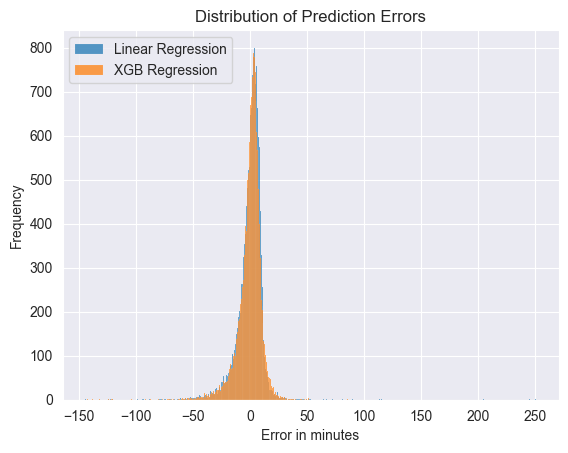

In [4]:
from sklearn.ensemble import ExtraTreesRegressor

XGB = XGBRegressor(n_estimators=2000, max_depth=5, learning_rate=0.005, reg_alpha=0.1, reg_lambda=0.1)
XGB.fit(X_train, y_train)

LinReg = LinearRegression()
LinReg.fit(X_train, y_train)

regression_prediction = LinReg.predict(X_test)
regression_error = regression_prediction - y_test
print('\nLinearRegression------------------------------')
print('R sqruare of regression...', LinReg.score(X_test,y_test))
print('RMSE of regression...', sqrt(mean_squared_error(y_test, regression_prediction)))

xgb_regression_prediction = XGB.predict(X_test)
xgb_regression_error = xgb_regression_prediction - y_test
print('\nXGBRegressor------------------------------')
print('Gradient Boosting Regression R Square...',XGB.score(X_test,y_test))
print('RMSE of Graident Bossting Regression...',sqrt(mean_squared_error(y_test, xgb_regression_prediction)))

sns.histplot(regression_error, kde=False, label='Linear Regression')
sns.histplot(xgb_regression_error, kde=False, label='XGB Regression')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error in minutes')
plt.ylabel('Frequency')
plt.legend(['Linear Regression','XGB Regression'], loc = 2)
plt.show()

# Bias Variance Analysis

In [5]:

from mlxtend.evaluate import bias_variance_decomp

linear_model = LinearRegression()
linear_mse, linear_bias, linear_variance = bias_variance_decomp(linear_model, X_train.values, y_train.values, X_test.values, y_test.values, loss='mse', num_rounds=5, random_seed=1)

xgb_model = XGBRegressor(n_estimators=2000, max_depth=5, learning_rate=0.005, reg_alpha=0.1, reg_lambda=0.1)
xgb_mse, xgb_bias, xgb_variance= bias_variance_decomp(xgb_model, X_train.values, y_train.values, X_test.values, y_test.values, loss='mse', num_rounds=5, random_seed=1)

print('\nBias-Variance Analysis for Linear Regression:')
print('RMSE:', sqrt(linear_mse))
print('Bias:', linear_bias)
print('Variance:', linear_variance)

print('\nBias-Variance Analysis for XGBoost Regressor:')
print('RMSE:', sqrt(xgb_mse))
print('Bias:', xgb_bias)
print('Variance:', xgb_variance)


Bias-Variance Analysis for Linear Regression:
RMSE: 11.332851210719562
Bias: 128.31068321870515
Variance: 0.12283334560271425

Bias-Variance Analysis for XGBoost Regressor:
RMSE: 10.728889624480336
Bias: 113.87907425906376
Variance: 1.2299983152180747


# Plotting learning curves

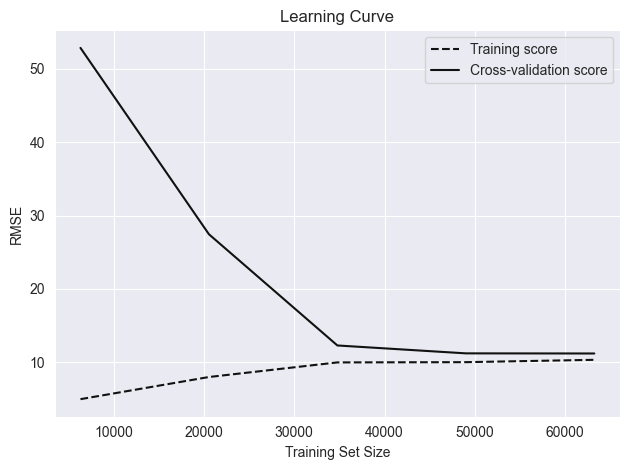

In [6]:
from sklearn.model_selection import learning_curve

X = prediction_df[INDATA]
y = prediction_df['Full_min']

# Choose model to test
model = xgb_model

train_sizes, train_scores, test_scores = learning_curve(model, X, y, scoring='neg_mean_squared_error')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
    
train_rmse = np.sqrt(-train_mean)
test_rmse = np.sqrt(-test_mean)

plt.subplots(1)
plt.plot(train_sizes, train_rmse, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_rmse, color="#111111", label="Cross-validation score")


plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSE"), plt.legend(loc="best")
plt.tight_layout()
plt.show()